In [2]:
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset

In [3]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func=func
        
    def forward(self, x): return self.func(x)

In [40]:



seqmod = nn.Sequential(
    Lambda(pprocess),
    nn.Conv2d(1,  16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0),-1))
)

In [8]:
lr = 0.1

In [9]:
loss_func = F.cross_entropy

In [12]:
class WrappedDataLoader():
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self): return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for x,y in batches: yield(self.func(x), y)

In [ ]:
model,opt = get_model()
loss_func(model(xb), yb)



In [10]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [11]:


def get_data(train_ds, valid_ds, bs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True),
            DataLoader(valid_ds, batch_size=bs*2))



In [ ]:


import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl: loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[loss_batch(model, loss_func, xb, yb)
                                for xb,yb in valid_dl])
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

        print(epoch, val_loss)




In [ ]:
train_dl,valid_dl = get_data(train_ds, valid_ds, bs)
model,opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

#### TEST BED

##### Get data

In [43]:

from pathlib import Path
import requests
import pickle, gzip
from matplotlib import pyplot
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
%matplotlib inline

class data_preprocessor():
    
    def __init__(self, download = True, bs = 64):
        
        self.DATA_PATH = Path('data')
        self.PATH = self.DATA_PATH/'mnist'
        self.download = download
        self.bs = bs
        
    def pprocess(x): return x.view(-1,1,28,28)
    
    
    def find_data(self):
        if self.download == True:
            

            self.PATH.mkdir(parents=True, exist_ok=True)

            URL='http://deeplearning.net/data/mnist/'
            self.FILENAME='mnist.pkl.gz'

            if not (self.PATH/self.FILENAME).exists():
                content = requests.get(URL+self.FILENAME).content
                (self.PATH/self.FILENAME).open('wb').write(content)


            with gzip.open(self.PATH/self.FILENAME, 'rb') as f:
                ((self.x_train, self.y_train), (self.x_valid, self.y_valid), _) = pickle.load(f, encoding='latin-1')
                
        
    def check_data(self):
        pyplot.imshow(self.x_train[0].reshape((28,28)), cmap="gray")
        self.x_train.shape
    
    
        
    def torchify(self):
    
        self.x_train,self.y_train,self.x_valid,self.y_valid = map(torch.tensor, (self.x_train,self.y_train,self.x_valid,self.y_valid))
        n,c = self.x_train.shape
        self.x_train, self.x_train.shape, self.y_train.min(), self.y_train.max()
        
    def get_dataset(self):
        self.train_dataset = TensorDataset(self.x_train, self.y_train)
        self.valid_dataset = TensorDataset(self.x_valid, self.y_valid)
        
    def create_dataloader(self):
        
        self.train_dl = WrappedDataLoader(self.train_dataset,pprocess, self.bs, shuffle = True )
        self.valid_dl = WrappedDataLoader(self.valid_dataset, pprocess)
        return self.train_dl, self.valid_dl, self.bs
    class WrappedDataLoader():
        def __init__(self, dl, func):
            self.dl = dl
            self.func = func

        def __len__(self): return len(self.dl)

        def __iter__(self):
            batches = iter(self.dl)
            for x,y in batches: yield(self.func(x), y)
    

In [44]:
preprocess = data_preprocessor()

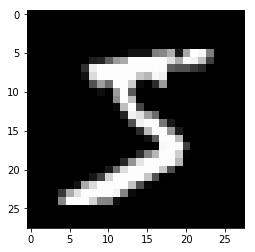

In [45]:
preprocess.find_data()
preprocess.check_data()
preprocess.torchify()



In [46]:
preprocess.get_dataset()

In [47]:
train_dl, valid_dl, bs = preprocess.create_dataloader()

NameError: name '_data_preprocessor__WrappedDataLoader' is not defined

In [27]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,  16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1,1,28,28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1,xb.size(1))

In [28]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [35]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl: 
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[loss_batch(model, loss_func, xb, yb)
                                for xb,yb in valid_dl])
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

        print(epoch, val_loss)

In [41]:
epochs = 10 # how many epochs to train for
lr=0.1

opt = optim.SGD(seqmod.parameters(), lr=lr, momentum=0.9)
loss_func = F.cross_entropy
xb, yb = next(iter(valid_dl))
loss_func(seqmod(xb), yb)


fit(epochs, seqmod, loss_func, opt, train_dl, valid_dl)



0 0.308093223868
1 0.289697942284
2 0.186805456384
3 0.175393324814
4 0.176690834204
5 0.135605120588
6 0.129173381042
7 0.132836969606
8 0.126364799296
9 0.122449902606


In [21]:
class WrappedDataLoader():
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self): return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for x,y in batches: yield(self.func(x), y)

In [22]:

#### Do not use at the moment
train_dl,valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)



NameError: name 'train_ds' is not defined

In [87]:


model = nn.Sequential(
    nn.Conv2d(1,  16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1), nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0),-1))
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)



In [88]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

NameError: name 'fit' is not defined